In [112]:
using ComputationalHeatTransfer
using LaTeXStrings
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
using JLD2


cd(dirname(pwd()))
cd("src") 
includet("OneDOHP.jl")
using ..OneDOHP

┌ Error: Failed to revise C:\Users\liyux\.julia\packages\CommonMark\Cmk5S\src\parsers\blocks.jl
│   exception = Revise.ReviseEvalException("C:\\Users\\liyux\\.julia\\packages\\CommonMark\\Cmk5S\\src\\parsers\\blocks.jl:29", ErrorException("invalid redefinition of type Parser"), Any[(top-level scope at blocks.jl:29, 1)])
└ @ Revise C:\Users\liyux\.julia\packages\Revise\3RMhb\src\packagedef.jl:714


┌ Error: Failed to revise C:\Users\liyux\.julia\packages\CommonMark\Cmk5S\src\CommonMark.jl
│   exception = Revise.ReviseEvalException("C:\\Users\\liyux\\.julia\\packages\\CommonMark\\Cmk5S\\src\\CommonMark.jl:3", ArgumentError("Package CommonMark does not have URIs in its dependencies:\n- If you have CommonMark checked out for development and have\n  added URIs as a dependency but haven't updated your primary\n  environment's manifest file, try `Pkg.resolve()`.\n- Otherwise you may need to report an issue with CommonMark"), Any[(top-level scope at CommonMark.jl:3, 1)])
└ @ Revise C:\Users\liyux\.julia\packages\Revise\3RMhb\src\packagedef.jl:714
┌ Error: Failed to revise C:\Users\liyux\.julia\packages\Tokenize\FGrTw\src\lexer.jl
│   exception = Revise.ReviseEvalException("C:\\Users\\liyux\\.julia\\packages\\Tokenize\\FGrTw\\src\\lexer.jl:1105", TypeError(:typeassert, "", JuliaInterpreter.FrameCode, 306 => :ALMOST_EQUAL_OR_EQUAL_TO), Any[(Symbol(::Tokenize.Tokens.Kind) at Enums.jl:26, 1

In [113]:
using Plots
gr()  

Plots.GRBackend()

## unit test
### test liquid h and vapor h in a one-loop OHP heating problem-with no dynamics
### plate temperature:  constant uniform 296 K, tube initial temperature uniform 295 K 

### conduction only

# Properies

In [114]:
tube_d = 1e-3; # tube diameter

### Solid Physical parameters

In [115]:
ρ = 2700; # density
c = 8.97e02; # specific heat
k = 1.67e02; # heat conductivity
# d = 2e-3;
plate_d = 1e-3;  # plate thickness
params = HeatConductionParameters(ρ,c,k,thickness=plate_d)

HeatConductionParameters(2700.0, 897.0, 167.0, 6.895412692514142e-5, 0.001)

### Fluid Physical parameters

In [116]:
fluid_type = "butane"
Tᵥ = 295.0

295.0

In [117]:
Cpₗ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",0.0,fluid_type)
ρₗ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",0.0,fluid_type)
μₗ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",0.0,fluid_type)
hₗ = CoolProp.PropsSI("H","T",Tᵥ,"Q",0.0,fluid_type)
kₗ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",0.0,fluid_type)
Prₗ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",0.0,fluid_type)

Cpᵥ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",1.0,fluid_type)
ρᵥ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",1.0,fluid_type)
μᵥ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",1.0,fluid_type);
hᵥ = CoolProp.PropsSI("H","T",Tᵥ,"Q",1.0,fluid_type)
kᵥ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",1.0,fluid_type)
Prᵥ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",1.0,fluid_type)

σ = CoolProp.PropsSI("I","T",Tᵥ,"Q",0.0,fluid_type)
P = CoolProp.PropsSI("P","T",Tᵥ,"Q",0.0,fluid_type)
R = CoolProp.PropsSI("GAS_CONSTANT","T",Tᵥ,"Q",1.0,fluid_type)
M = CoolProp.PropsSI("M","T",Tᵥ,"Q",1.0,fluid_type)
Rkg = R/M

νₗ = μₗ/ρₗ
νᵥ = μᵥ/ρᵥ;
hₗᵥ = hᵥ-hₗ;

# Plate Conduction

### Geometry parameters

In [118]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

In [119]:
xlim = (-Lx/2,Lx/2) .*1.0
ylim = (-Ly/2,Ly/2) .*1.0
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.3)


(0.0005516330154011314, 0.001323919236962715)

### Set up the evaporator and condenser

In [120]:
inch = 2.54e-2;

In [121]:
power = 40 #watts
total_heater_area = 2.0inch*2.0inch;

In [122]:
qe = power/total_heater_area
hc = 1500.0
Tc = Tᵥ

295.0

In [123]:
eb1 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((0.7inch,-0.0),0.0)
Tfe(eb1)

eb2 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((-0.7inch,-0.0),0.0)
Tfe(eb2)

cb1 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((-2.5inch,-0.0),0.0)
Tfc(cb1)

cb2 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((2.5inch,-0.0),0.0)
Tfc(cb2)

eparams1 = PrescribedHeatFluxRegion(qe,eb1);
eparams2 = PrescribedHeatFluxRegion(qe,eb2);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

In [124]:
ds = 1.5Δx
nturn = 16
width_ohp = 46.25*1e-3
length_ohp = 133.83*1e-3
gap = plate_d
pitch = width_ohp/(2*nturn+1)
x0, y0 = length_ohp/2, width_ohp/2

# x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,length_ohp,gap,ds,x0,y0,false,false,3pi/2)
one_loop_gap = 10*plate_d
x, y, xf, yf = construct_oneloop_curve(0,0,ds,length_ohp,one_loop_gap,pi/2)


ohp = BasicBody(x,y)

Basic pointwise-specified body with 362 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


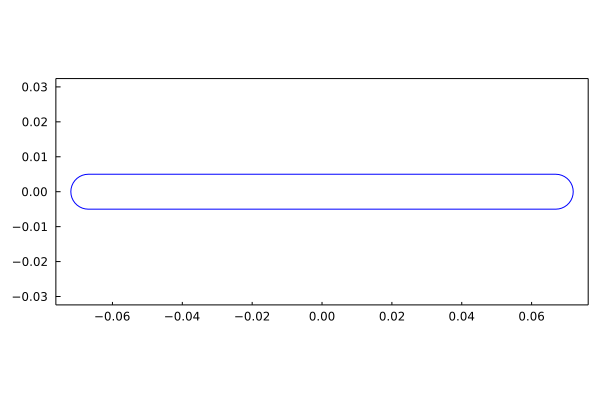

In [125]:
plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)

In [126]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)

LineSourceParams{BasicBody{362,RigidBodyTools.ClosedBody}}(Basic pointwise-specified body with 362 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
)

### Create the system

In [127]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom,qflux=[eparams1,eparams2],qmodel=[cparams1,cparams2])

Unbounded Heat conduction system on a grid of size 280 x 120 and 0 static immersed points


# OHP inner part

### Dimensional conversion

In [128]:
t_to_nondi_t = μₗ/ρₗ/(tube_d^2)

0.2831486159429433

In [129]:
hl_to_nondihl = 4*tube_d/(μₗ*Cpₗ)

0.010113739664438532

In [130]:
hv_to_nondihv =  4*Rkg*Tᵥ^2*tube_d/(P*hₗᵥ*νₗ)

2.1888035096259424

In [131]:
nondihv_tonondihl = hl_to_nondihl / hv_to_nondihv

0.0046206704347650325

In [132]:
nondiqv_to_qv = Tᵥ *(pi*tube_d) / hv_to_nondihv

0.42341390112599475

In [133]:
nondiql_to_ql = Tᵥ * (pi*tube_d)/ hl_to_nondihl

91.63473290376008

In [134]:
nondi_Q_to_Q = nondiqv_to_qv
function di_T_to_nondi_T(di_T;T0=295.0) 
    
    di_T/T0
    
end

di_T_to_nondi_T (generic function with 1 method)

In [135]:
    ω = sqrt(2.45E+03);
    ℘L = 2.05E+05;
    k = 0.106024683

    θinitial=1.0
    θc = 1.0; # useless

    Hwc = 0.0; #not useful later on. H between wall and condenser, 

    htₗ = 4.62e2 # Nusselt number 4.36
    Htₗ_real = 4*htₗ*tube_d/(μₗ*Cpₗ)
    Htₗ_OHP  = Htₗ_real/nondihv_tonondihl

    Hδ = kₗ/(tube_d/2) * hv_to_nondihv


464.1343957425323

In [136]:
    nondi_diameter = 6.56e-3 # dimensionless diameter
    L = 2.0 + one_loop_gap*pi/length_ohp  # total length of the pipe when streched to a 1D pipe
#     L = 34.35  # total length of the pipe when streched to a 1D pipe
    L2D = 1.0 # the actual length of the bended pipe in the real world
    angle = 0*pi/2 # inclination angle 
    ΔTthres = 0.3/295.0 *100; # use a small threshold
    closedornot = true

true

In [137]:
    nucleatenum = 256
    Xstations = sort(rand(nucleatenum).*L);
#     Xstations = LinRange(0.0,L-L/nucleatenum,nucleatenum)
#     boilingΔt = 0.05

In [138]:
tube = Tube(nondi_diameter,L,L2D,angle,ΔTthres,closedornot);

In [139]:
# useless
Xe = map(tuple, [1.0], [3.0])
We = [0.0]
evap = Evaporator(Xe,We);

In [140]:
# useless
Xc = map(tuple, [0.0,3.0], [1.0,4.0])
cond = Condenser(θc,Xc,Hwc);

In [141]:
# X0,realratio = randomXp(L,numofslugs=60,chargeratio=0.45)
X0 = [(L/2,L/2 + 1.0)]

dXdt0_l = zeros(length(X0))
dXdt0_r = zeros(length(X0))
dXdt0 = map(tuple,dXdt0_l,dXdt0_r)


# construct liquids
N=numpts(ohp)

ρ = 102.593344 # density ratio
Xarrays,θarrays = constructXarrays(X0,N,θinitial,L)
liquids=Liquid(Htₗ_OHP,ρ,ω,℘L,X0,dXdt0,Xarrays,θarrays);


In [142]:
realratio

LoadError: [91mUndefVarError: realratio not defined[39m

In [143]:
# P = [1.0,1.0,1.0,1.0,1.0]; # closed end

γ = 1.4;
# Hδ = 4.64E+02
P = 0*zeros(length(X0)) .+ 1.0;
δ = 0*zeros(length(X0)) .+ 2.0E-01;
# δ = 0*zeros(length(X0)) .+ 2.78E-02;
# δ = 0*zeros(length(X0)) .+ 2.78E-02 .* 10; # use a random film thickness
vapors=Vapor(γ,Hδ,P,δ);

In [144]:
di_T_to_nondi_T(Tᵥ)

1.0

In [145]:
Xwallarray,θwallarray = constructXarrays(sys.qline[1].arccoord,L,θinitial)

([0.003107175685366934, 0.0093215270561008, 0.01553587842683467, 0.021750229797568434, 0.0279645811683023, 0.03417893253903607, 0.04039328390976993, 0.0466076352805038, 0.05282198665123767, 0.059036338021971536  …  2.179559529499081, 2.1860504821007583, 2.1925414347024357, 2.199032387304113, 2.2055233399057905, 2.212014292507468, 2.2185052451091454, 2.224996197710823, 2.2314871503125, 2.2347450238055586], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [146]:
α = 1.154e-5 # nondimensional thermal diffusivity = (αₐ d^2) / (νₗ height^2)
# Xwallarray,θwallarray = constructXarrays(L,N,θinitial)
Xwallarray,θwallarray = constructXarrays(sys.qline[1].arccoord,L,θinitial)
θwallarray .= di_T_to_nondi_T(Tᵥ);

wall = Wall(α,Δt,Xstations,Xwallarray,θwallarray);

In [147]:
sys0_nomapping = PHPSystem_nomapping(tube,evap,cond,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [148]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors,wall,mapping);

### construct state vector U

In [149]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = nondi_PtoD(P) .* Lvaporplug
# M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [150]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cbst = CallbackSet(cb_boiling,cb_merging);

# combine inner tube and plate together

In [151]:
tspan = (0.0, 1.0);
dt_record = tspan[2] /100;

tstep=1e-3

N_iter = 1
# tstep_plate = tstep/N_iter
# dt_record = tstep

1

In [152]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)
# Tplate = temperature(integrator_plate);
temperature(integrator_plate) .= Tᵥ  .+ 1.0;

In [153]:
p = sys0
u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_everystep=false, dt=tstep*t_to_nondi_t, callback=cbst);

In [154]:
plate_hist = []
tube_hist  = []

currentsys = integrator_tube.p
currentsys = getcurrentsys(integrator_tube.u,currentsys);

In [155]:

@time for t in tspan[1]:tstep:tspan[2]
    

#   for j in 1:N_iter
        currentsys.wall.θarray = di_T_to_nondi_T(temperature_linesource(integrator_plate))
        currentsys = getcurrentsys(integrator_tube.u,currentsys)


        nondi_qtmp = sys_to_heatflux(currentsys)
        qtmp = nondi_Q_to_Q*nondi_qtmp
        set_linesource_strength!(sys,qtmp)


#      ADI_timemarching!(temperature(integrator_plate),sys,tstep)
#     end
    integrator_plate.t += tstep
    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t*t_to_nondi_t-tstep*t_to_nondi_t,integrator_plate.t*t_to_nondi_t), currentsys)
    integrator_tube = init(prob, RK4(), callback=cbst, dt=tstep*t_to_nondi_t);
#     step!(integrator_tube);
    step!(integrator_tube,tstep*t_to_nondi_t,true);

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)
    end
    
end

0.010000000000000002
0.02000000000000001
0.03000000000000002
0.04000000000000003
0.05000000000000004
0.060000000000000046
0.07000000000000005
0.08000000000000006
0.09000000000000007
0.10000000000000007
0.11000000000000008
0.12000000000000009
0.1300000000000001
0.1400000000000001
0.1500000000000001
0.16000000000000011
0.17000000000000012
0.18000000000000013
0.19000000000000014
0.20000000000000015
0.21000000000000016
0.22000000000000017
0.23000000000000018
0.24000000000000019
0.25000000000000017
0.2600000000000002
0.2700000000000002
0.2800000000000002
0.2900000000000002
0.3000000000000002
0.3100000000000002
0.32000000000000023
0.33000000000000024
0.34000000000000025
0.35000000000000026
0.36000000000000026
0.3700000000000003
0.3800000000000003
0.3900000000000003
0.4000000000000003
0.4100000000000003
0.4200000000000003
0.4300000000000003
0.44000000000000034
0.45000000000000034
0.46000000000000035
0.47000000000000036
0.48000000000000037
0.4900000000000004
0.5000000000000003
0.51000000000000

In [156]:
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)

1.0010000000000006


In [157]:
sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
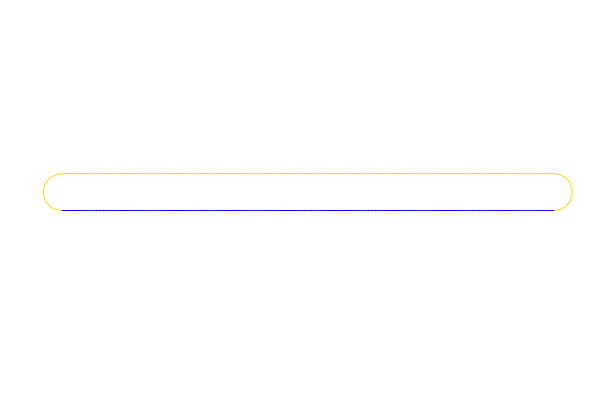

In [182]:
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",border=:none,axis=nothing)
end

In [187]:
Htmp = sys_to_Harray(sysfinal[end])
plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",border=:none,axis=nothing)

savefig("OHP.pdf")

# plot the OHP

In [174]:
paraₗ = 4*htₗ/(tube_d*ρₗ*Cpₗ)
t = LinRange(tspan[1],tspan[2],length(sysfinal))

Thist_refₗ = (Tᵥ + 1.0) .- exp.(-paraₗ .* (t .- t[1]));


In [175]:
Verification_Thist = zeros(length(sysfinal))
Verification_Thist[1] = Tᵥ
for i = 1:length(sysfinal)-1
    Verification_Thist[i+1] = (maximum(sysfinal[i].liquid.θarrays[1]) * Tᵥ)
end

In [181]:
err = norm(Verification_Thist - Thist_refₗ,Inf)

6.252776074688882e-13

In [202]:
plot(t,Thist_refₗ,linewidth=3.0,label="numerical solution")
plot!(t[1:5:end],Verification_Thist[1:5:end],ylabel="T [K]",xlabel="t [s]",markershape=:auto,label="reference",legend=:bottomright)
savefig("validation.pdf")